In [1]:
import pandas as pd

# Read and concatenate the data files
file_paths = ['/kaggle/input/netflix-prize-data/combined_data_1.txt'
#               , '/kaggle/input/netflix-prize-data/combined_data_2.txt'
#               ,'/kaggle/input/netflix-prize-data/combined_data_3.txt'
#               ,'/kaggle/input/netflix-prize-data/combined_data_4.txt'
             ]

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, header=None, names=['userId', 'rating'], usecols=[0, 1])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Identify indices of NaN values in 'rating' column
nan_indices = df[df['rating'].isna()].index.to_list()

# Extract ratings data
ratings = []
for i in range(len(nan_indices)):
    start_index = nan_indices[i] + 1
    end_index = nan_indices[i + 1] - 1 if i + 1 < len(nan_indices) else None
    temp_df = df.loc[start_index:end_index].reset_index(drop=True)
    temp_df['movieId'] = df.loc[nan_indices[i], 'userId'][:-1]
    ratings.append(temp_df)

df = pd.concat(ratings, ignore_index=True)
del ratings, dfs

In [2]:
# df = df.sample(frac=0.5)
df.head()

,userId,rating,movieId
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1


In [3]:
import numpy as np

df.userId = df.userId.astype(int)
df.movieId = df.movieId.astype(int)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

df.head()

,userId,rating,movieId
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1


In [4]:
train_indexs = np.random.rand(len(df)) <0.8
train_df = df[train_indexs]
test_df = df[~train_indexs]
train_df.shape, test_df.shape

((19244517, 3), (4809247, 3))

In [5]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()

In [6]:
del df

In [7]:
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,userId,rating,movieId
0,822109,5.0,1
1,885013,4.0,1
2,30878,4.0,1
3,823519,3.0,1
4,893988,3.0,1


In [8]:
train_indexs = np.random.rand(len(train_df)) <0.8
valid_df = train_df[~train_indexs]
train_df = train_df[train_indexs]
train_df.shape, valid_df.shape

((15395704, 3), (3848813, 3))

In [9]:
n_factors = 64

In [10]:
import keras
from keras.layers import Input, Embedding, Flatten
from keras.layers.merging import dot


user_input = Input(shape=(1, ), name='user_input', dtype="int64")
item_input = Input(shape=(1, ), name='item_input', dtype="int64")


user_embeddings = Embedding(n_users, n_factors, name='user_embeddings')(user_input)
item_embeddings = Embedding(n_items, n_factors, name='item_embeddings')(item_input)

user_vector = Flatten(name='user_vectors')(user_embeddings)
item_vector = Flatten(name='item_vectors')(item_embeddings)


similarity = dot([user_vector, item_vector], axes=1)

model = keras.models.Model([user_input, item_input], similarity)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embeddings (Embedding)    (None, 1, 64)        30128512    ['user_input[0][0]']             
                                                                                                  
 item_embeddings (Embedding)    (None, 1, 64)        287936      ['item_input[0][0]']             
                                                                                              

In [11]:
hist = model.fit(x = [train_df.userId.values, train_df.movieId.values], y=train_df.rating, batch_size=4096*2, epochs=16, 
                    validation_data=([valid_df.userId.values, valid_df.movieId.values], valid_df.rating), verbose=1)

Epoch 1/16
1880/1880 [==============================] - 44s 21ms/step - loss: 12.6174 - val_loss: 11.8442
Epoch 2/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.8076 - val_loss: 11.7911
Epoch 3/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7786 - val_loss: 11.7788
Epoch 4/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7657 - val_loss: 11.7737
Epoch 5/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7542 - val_loss: 11.7713
Epoch 6/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7413 - val_loss: 11.7708
Epoch 7/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7268 - val_loss: 11.7723
Epoch 8/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7125 - val_loss: 11.7752
Epoch 9/16
1880/1880 [==============================] - 39s 21ms/step - loss: 11.7001 - val_loss: 11.7797
Epoch 10/16
1880/1880 [=======================

In [12]:
del train_df, valid_df

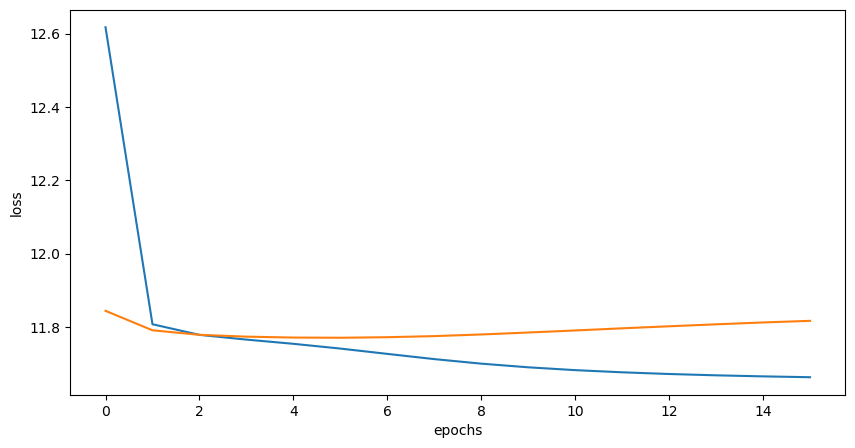

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

y_pred = model.predict([test_df.userId, test_df.movieId])

150289/150289 [==============================] - 287s 2ms/step


In [15]:
RMSE = mean_squared_error(test_df.rating, y_pred, squared=False)
RMSE

3.4378855

In [16]:
MAPE = mean_absolute_percentage_error(test_df.rating, y_pred)
MAPE

0.87454146